# Layout optimization

This example demonstrates some basics about running wind farm optimization tasks with `foxes`. 

It requires the installation of two additional python packages:

- [foxes-opt](https://github.com/FraunhoferIWES/foxes-opt): Adds optimization functionalities to `foxes`, based on the [iwopy](https://github.com/FraunhoferIWES/iwopy) interface (both also by Fraunhofer IWES, see links for details),
- [pymoo](https://pymoo.org/): Contains a number of very nice genetic algorithm implementations. Within `foxes` we do that implicitely via the `iwopy` interface.

These dependencies can conveniently be installed by
```console
pip install foxes[opt]
```
for standard users, or
```console
pip install -e .[opt]
```
from the `foxes` root folder for developers.

Here are the required imports for this example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import foxes
import foxes.utils.geom2d as gm
import foxes.variables as FV
from iwopy.interfaces.pymoo import Optimizer_pymoo
from foxes_opt.problems.layout import FarmLayoutOptProblem
from foxes_opt.objectives import MaxFarmPower
from foxes_opt.constraints import FarmBoundaryConstraint, MinDistConstraint

Let's initialize the *foxes* engine, which will be used for all calculations:

In [2]:
engine = foxes.Engine.new(
    "process",
    chunk_size_states=500,
    chunk_size_points=5000,
    verbosity=0,
)
engine.initialize()

In the following we are tackling the problem of optimizing a wind farm layout for a site near Bremen, Germany. The data of a (coarse) wind rose with 216 states is provided as static data file with name `"wind_rose_bremen.csv"`:
```
state,wd,ws,weight
0,0.0,3.5,0.00158
1,0.0,6.0,0.00244
2,0.0,8.5,0.00319
3,0.0,12.5,0.0036700002
4,0.0,17.5,0.00042
...
```
First, let's create the states object and have a look at the wind rose:

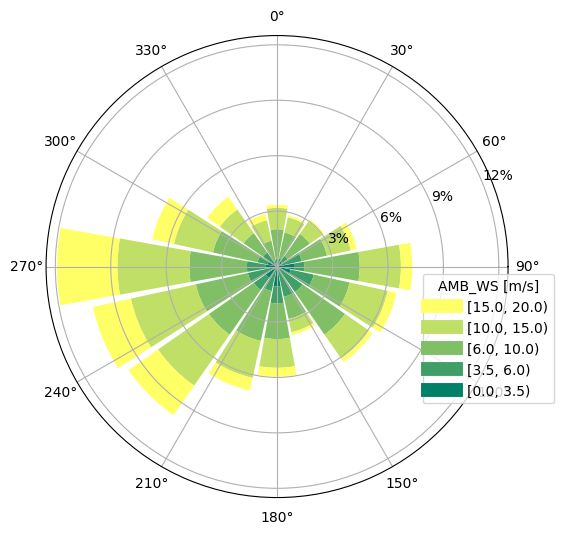

In [3]:
states = foxes.input.states.StatesTable(
    data_source="wind_rose_bremen.csv",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.WEIGHT: "weight"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0.0, 0.0, 100.0])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

Next, we need to specify the area within which the turbines are allowed to move during optimization. We use the `foxes.utils.geom2d` sub-package for that purpose (imported as `gm`, see above) which allows us to add and subtract polygons, circles, etc.

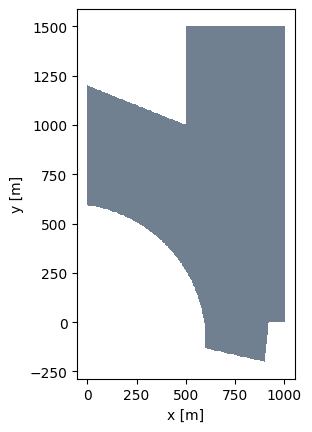

In [4]:
boundary = (
    gm.ClosedPolygon(
        np.array([[0, 0], [0, 1200], [1000, 800], [900, -200]], dtype=np.float64)
    )
    + gm.ClosedPolygon(
        np.array([[500, 0], [500, 1500], [1000, 1500], [1000, 0]], dtype=np.float64)
    )
    - gm.Circle([-100.0, -100.0], 700)
)

fig, ax = plt.subplots()
boundary.add_to_figure(ax)
plt.show()

Later on we wish to apply boundary constraints that make sure all turbines are placed within this area geometry. These conditions make use of the minimal distance calculation from each point in question to the boundary. We can check the results by plotting again, now using the `fill_mode` option:

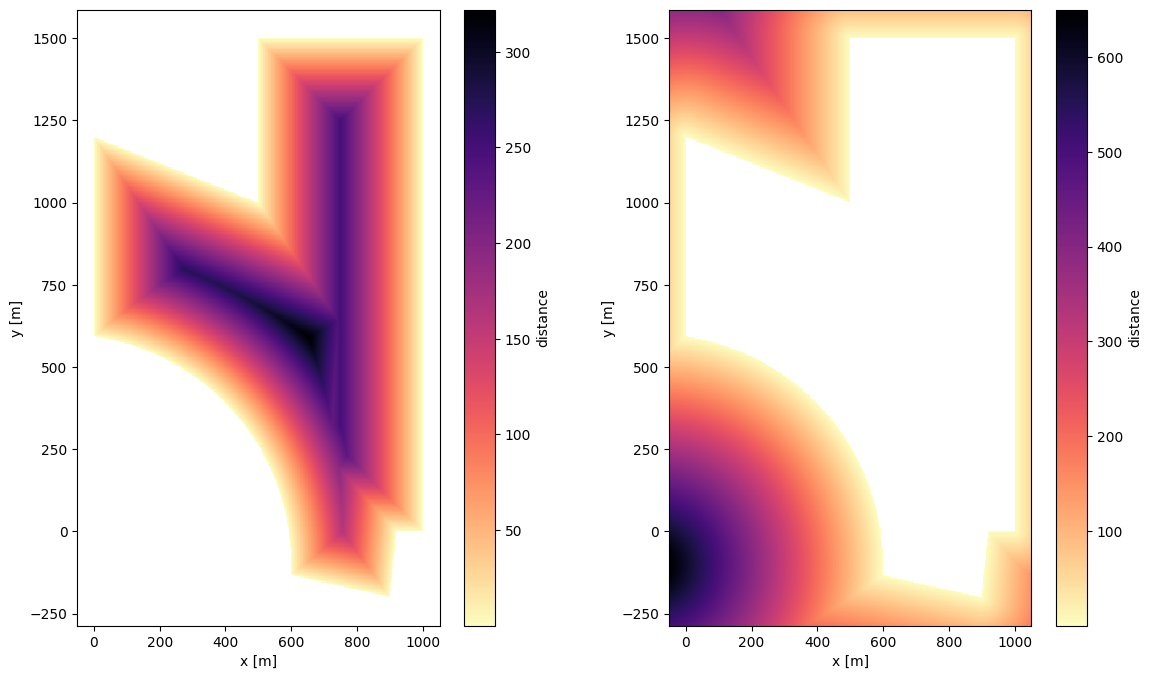

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
boundary.add_to_figure(axs[0], fill_mode="dist_inside")
boundary.add_to_figure(axs[1], fill_mode="dist_outside")
plt.show()

We now setup the model book and a wind farm with 10 turbines in some initial layout, including the boundary:

Turbine 0, T0: xy=(500.00, 500.00), NREL5MW
Turbine 1, T1: xy=(550.00, 550.00), NREL5MW
Turbine 2, T2: xy=(600.00, 600.00), NREL5MW
Turbine 3, T3: xy=(650.00, 650.00), NREL5MW
Turbine 4, T4: xy=(700.00, 700.00), NREL5MW
Turbine 5, T5: xy=(750.00, 750.00), NREL5MW
Turbine 6, T6: xy=(800.00, 800.00), NREL5MW
Turbine 7, T7: xy=(850.00, 850.00), NREL5MW
Turbine 8, T8: xy=(900.00, 900.00), NREL5MW
Turbine 9, T9: xy=(950.00, 950.00), NREL5MW


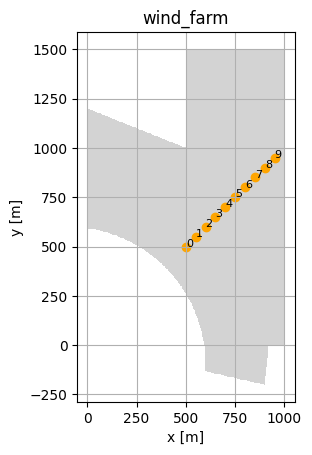

In [6]:
farm = foxes.WindFarm(boundary=boundary)
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=np.array([500.0, 500.0]),
    xy_step=np.array([50.0, 50.0]),
    n_turbines=10,
    turbine_models=["NREL5MW"],
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure()
plt.show()

Notice the appearing turbine model `layout_opt`. This is not part of the model book but will be defined shortly by the optimization problem. In the context of the turbine models it defines where in the model order the optimization variables application should be applied. In our case we are optimizing the (X, Y)-coordinates of the turbines, and they should be updated at the very beginning.

Let's new define the algorithm and the layout optimization problem. The latter should include boundary constraints and a minimal distance of 2 rotor diameters between turbines. Our objective is the maximization of the total wind farm power:

In [7]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah025_linear_k002"],
    partial_wakes=None,
    verbosity=0,
)

problem = FarmLayoutOptProblem("layout_opt", algo)
problem.add_objective(MaxFarmPower(problem))
problem.add_constraint(FarmBoundaryConstraint(problem))
problem.add_constraint(MinDistConstraint(problem, min_dist=2.0, min_dist_unit="D"))
problem.initialize()

Problem 'layout_opt' (FarmLayoutOptProblem): Initializing
---------------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 20
---------------------------------------------------------
  n_objectives: 1
  n_obj_cmptns: 1
---------------------------------------------------------
  n_constraints: 2
  n_con_cmptns: 55
---------------------------------------------------------


Notice that the two added constraint models imply a total of 55 individual constraint component functions. The wake model choice `Bastankhah025` corresponds to the `Bastankhah2014` deficit model with parameter `sbeta_factor=0.25`. This choice switches off the near wake modelling, rendering the model a bit smoother. This is for demonstrational purposes only and not required for running this example.

Next, we setup the optimizer. In our case we use the genetic algorithm [GA from pymoo](https://pymoo.org/algorithms/soo/ga.html) via the [iwopy](https://github.com/FraunhoferIWES/iwopy) interface, here in vectorized form (flag `vectorize=True`), with 100 generations (`n_max_gen=100`) with population size 50 (`pop_size=50`):

In [8]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(vectorize=True),
    algo_pars=dict(
        type="GA",
        pop_size=50,
        seed=42,
    ),
    setup_pars=dict(),
    term_pars=dict(
        type="default",
        n_max_gen=100,
        ftol=1e-6,
        xtol=1e-3,
    ),
)
solver.initialize()
solver.print_info()

Loading pymoo


pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)
Selecting termination: default (DefaultSingleObjectiveTermination)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 50
  seed: 42

Termination:
------------
  n_max_gen: 100
  ftol: 1e-06
  xtol: 0.001



After all the setup we can now solve the problem:

In [9]:
results = solver.solve()
solver.finalize(results)

print()
print(results)
print(results.problem_results)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       50 |  4.257950E+02 |  1.094916E+03 |             - |             -


     2 |      100 |  2.589298E+02 |  7.141458E+02 |             - |             -


     3 |      150 |  2.108843E+02 |  5.097684E+02 |             - |             -


     4 |      200 |  2.011586E+02 |  3.869307E+02 |             - |             -


     5 |      250 |  1.250281E+02 |  3.238949E+02 |             - |             -


     6 |      300 |  1.250281E+02 |  2.668302E+02 |             - |             -


     7 |      350 |  1.250281E+02 |  2.500554E+02 |             - |             -


     8 |      400 |  1.011095E+02 |  2.198486E+02 |             - |             -


     9 |      450 |  8.571793E+01 |  1.998508E+02 |             - |             -


    10 |      500 |  8.571793E+01 |  1.775495E+02 |             - |             -


    11 |      550 |  2.695093E+01 |  1.482376E+02 |             - |             -


    12 |      600 |  2.695093E+01 |  1.369663E+02 |             - |             -


    13 |      650 |  2.695093E+01 |  1.255097E+02 |             - |             -


    14 |      700 |  2.461710E+01 |  1.135664E+02 |             - |             -


    15 |      750 |  2.461710E+01 |  1.098324E+02 |             - |             -


    16 |      800 |  2.461710E+01 |  9.266611E+01 |             - |             -


    17 |      850 |  2.446678E+01 |  8.484456E+01 |             - |             -


    18 |      900 |  2.440080E+01 |  7.151751E+01 |             - |             -


    19 |      950 |  2.440080E+01 |  5.917821E+01 |             - |             -


    20 |     1000 |  1.998273E+01 |  4.871628E+01 |             - |             -


    21 |     1050 |  1.019366E+01 |  4.071983E+01 |             - |             -


    22 |     1100 |  6.4405916400 |  3.193676E+01 |             - |             -


    23 |     1150 |  4.9794099827 |  2.349004E+01 |             - |             -


    24 |     1200 |  0.000000E+00 |  1.738912E+01 | -5.005446E-01 | -5.005446E-01


    25 |     1250 |  0.000000E+00 |  1.137290E+01 | -5.003716E-01 | -5.005446E-01


    26 |     1300 |  0.000000E+00 |  6.4573986190 | -5.001255E-01 | -5.007026E-01


    27 |     1350 |  0.000000E+00 |  2.2839046772 | -5.002029E-01 | -5.043050E-01


    28 |     1400 |  0.000000E+00 |  0.0401518036 | -5.002328E-01 | -5.046954E-01


    29 |     1450 |  0.000000E+00 |  0.000000E+00 | -5.010270E-01 | -5.047884E-01


    30 |     1500 |  0.000000E+00 |  0.000000E+00 | -5.018469E-01 | -5.047952E-01


    31 |     1550 |  0.000000E+00 |  0.000000E+00 | -5.033843E-01 | -5.048056E-01


    32 |     1600 |  0.000000E+00 |  0.000000E+00 | -5.045212E-01 | -5.052518E-01


    33 |     1650 |  0.000000E+00 |  0.000000E+00 | -5.047445E-01 | -5.054240E-01


    34 |     1700 |  0.000000E+00 |  0.000000E+00 | -5.049293E-01 | -5.054240E-01


    35 |     1750 |  0.000000E+00 |  0.000000E+00 | -5.051205E-01 | -5.058090E-01


    36 |     1800 |  0.000000E+00 |  0.000000E+00 | -5.053169E-01 | -5.059597E-01


    37 |     1850 |  0.000000E+00 |  0.000000E+00 | -5.055598E-01 | -5.067092E-01


    38 |     1900 |  0.000000E+00 |  0.000000E+00 | -5.058344E-01 | -5.067092E-01


    39 |     1950 |  0.000000E+00 |  0.000000E+00 | -5.061865E-01 | -5.072494E-01


    40 |     2000 |  0.000000E+00 |  0.000000E+00 | -5.064220E-01 | -5.073431E-01


    41 |     2050 |  0.000000E+00 |  0.000000E+00 | -5.068005E-01 | -5.081851E-01


    42 |     2100 |  0.000000E+00 |  0.000000E+00 | -5.070952E-01 | -5.085442E-01


    43 |     2150 |  0.000000E+00 |  0.000000E+00 | -5.074588E-01 | -5.085442E-01


    44 |     2200 |  0.000000E+00 |  0.000000E+00 | -5.078524E-01 | -5.093114E-01


    45 |     2250 |  0.000000E+00 |  0.000000E+00 | -5.082867E-01 | -5.098399E-01


    46 |     2300 |  0.000000E+00 |  0.000000E+00 | -5.087176E-01 | -5.098399E-01


    47 |     2350 |  0.000000E+00 |  0.000000E+00 | -5.091165E-01 | -5.099068E-01


    48 |     2400 |  0.000000E+00 |  0.000000E+00 | -5.095298E-01 | -5.102335E-01


    49 |     2450 |  0.000000E+00 |  0.000000E+00 | -5.098345E-01 | -5.105389E-01


    50 |     2500 |  0.000000E+00 |  0.000000E+00 | -5.101265E-01 | -5.108688E-01


    51 |     2550 |  0.000000E+00 |  0.000000E+00 | -5.104231E-01 | -5.112445E-01


    52 |     2600 |  0.000000E+00 |  0.000000E+00 | -5.107525E-01 | -5.114826E-01


    53 |     2650 |  0.000000E+00 |  0.000000E+00 | -5.110290E-01 | -5.118996E-01


    54 |     2700 |  0.000000E+00 |  0.000000E+00 | -5.112750E-01 | -5.124239E-01


    55 |     2750 |  0.000000E+00 |  0.000000E+00 | -5.115946E-01 | -5.124642E-01


    56 |     2800 |  0.000000E+00 |  0.000000E+00 | -5.118256E-01 | -5.126645E-01


    57 |     2850 |  0.000000E+00 |  0.000000E+00 | -5.121022E-01 | -5.126645E-01


    58 |     2900 |  0.000000E+00 |  0.000000E+00 | -5.123371E-01 | -5.128177E-01


    59 |     2950 |  0.000000E+00 |  0.000000E+00 | -5.125054E-01 | -5.128177E-01


    60 |     3000 |  0.000000E+00 |  0.000000E+00 | -5.126078E-01 | -5.129150E-01


    61 |     3050 |  0.000000E+00 |  0.000000E+00 | -5.127029E-01 | -5.129655E-01


    62 |     3100 |  0.000000E+00 |  0.000000E+00 | -5.127876E-01 | -5.129655E-01


    63 |     3150 |  0.000000E+00 |  0.000000E+00 | -5.128550E-01 | -5.131367E-01


    64 |     3200 |  0.000000E+00 |  0.000000E+00 | -5.129328E-01 | -5.132712E-01


    65 |     3250 |  0.000000E+00 |  0.000000E+00 | -5.130119E-01 | -5.132849E-01


    66 |     3300 |  0.000000E+00 |  0.000000E+00 | -5.130944E-01 | -5.133150E-01


    67 |     3350 |  0.000000E+00 |  0.000000E+00 | -5.131745E-01 | -5.133480E-01


    68 |     3400 |  0.000000E+00 |  0.000000E+00 | -5.132618E-01 | -5.134317E-01


    69 |     3450 |  0.000000E+00 |  0.000000E+00 | -5.133163E-01 | -5.134561E-01


    70 |     3500 |  0.000000E+00 |  0.000000E+00 | -5.133671E-01 | -5.134833E-01


    71 |     3550 |  0.000000E+00 |  0.000000E+00 | -5.134048E-01 | -5.134834E-01


    72 |     3600 |  0.000000E+00 |  0.000000E+00 | -5.134433E-01 | -5.136118E-01


    73 |     3650 |  0.000000E+00 |  0.000000E+00 | -5.134627E-01 | -5.136118E-01


    74 |     3700 |  0.000000E+00 |  0.000000E+00 | -5.134814E-01 | -5.136118E-01


    75 |     3750 |  0.000000E+00 |  0.000000E+00 | -5.135100E-01 | -5.136132E-01


    76 |     3800 |  0.000000E+00 |  0.000000E+00 | -5.135378E-01 | -5.136557E-01


    77 |     3850 |  0.000000E+00 |  0.000000E+00 | -5.135664E-01 | -5.136557E-01


    78 |     3900 |  0.000000E+00 |  0.000000E+00 | -5.135939E-01 | -5.136844E-01


    79 |     3950 |  0.000000E+00 |  0.000000E+00 | -5.136235E-01 | -5.137929E-01


    80 |     4000 |  0.000000E+00 |  0.000000E+00 | -5.136583E-01 | -5.137983E-01


    81 |     4050 |  0.000000E+00 |  0.000000E+00 | -5.136864E-01 | -5.138033E-01


    82 |     4100 |  0.000000E+00 |  0.000000E+00 | -5.137170E-01 | -5.138508E-01


    83 |     4150 |  0.000000E+00 |  0.000000E+00 | -5.137579E-01 | -5.138666E-01


    84 |     4200 |  0.000000E+00 |  0.000000E+00 | -5.137994E-01 | -5.139128E-01


    85 |     4250 |  0.000000E+00 |  0.000000E+00 | -5.138396E-01 | -5.140404E-01


    86 |     4300 |  0.000000E+00 |  0.000000E+00 | -5.138854E-01 | -5.140498E-01


    87 |     4350 |  0.000000E+00 |  0.000000E+00 | -5.139133E-01 | -5.141967E-01


    88 |     4400 |  0.000000E+00 |  0.000000E+00 | -5.139546E-01 | -5.141967E-01


    89 |     4450 |  0.000000E+00 |  0.000000E+00 | -5.140218E-01 | -5.147526E-01


    90 |     4500 |  0.000000E+00 |  0.000000E+00 | -5.141040E-01 | -5.156605E-01


    91 |     4550 |  0.000000E+00 |  0.000000E+00 | -5.142399E-01 | -5.156605E-01


    92 |     4600 |  0.000000E+00 |  0.000000E+00 | -5.144019E-01 | -5.157213E-01


    93 |     4650 |  0.000000E+00 |  0.000000E+00 | -5.147286E-01 | -5.157683E-01


    94 |     4700 |  0.000000E+00 |  0.000000E+00 | -5.154050E-01 | -5.165078E-01


    95 |     4750 |  0.000000E+00 |  0.000000E+00 | -5.157949E-01 | -5.165540E-01


    96 |     4800 |  0.000000E+00 |  0.000000E+00 | -5.160264E-01 | -5.166291E-01


    97 |     4850 |  0.000000E+00 |  0.000000E+00 | -5.163338E-01 | -5.166643E-01


    98 |     4900 |  0.000000E+00 |  0.000000E+00 | -5.165219E-01 | -5.166849E-01


    99 |     4950 |  0.000000E+00 |  0.000000E+00 | -5.165851E-01 | -5.167818E-01


   100 |     5000 |  0.000000E+00 |  0.000000E+00 | -5.166481E-01 | -5.169221E-01




Optimizer_pymoo: Optimization run finished
  Success: True
  Best maximize_power = 25846.105909172766

Results problem 'layout_opt':
------------------------------
  Float variables:
    0: X_0000 = 8.896358e+02
    1: Y_0000 = -1.973433e+02
    2: X_0001 = 1.084184e+01
    3: Y_0001 = 7.604301e+02
    4: X_0002 = 9.840827e+02
    5: Y_0002 = 8.443889e+02
    6: X_0003 = 9.159412e+02
    7: Y_0003 = 1.499215e+03
    8: X_0004 = 9.937176e+02
    9: Y_0004 = 4.555305e+02
    10: X_0005 = 8.251784e+00
    11: Y_0005 = 1.145879e+03
    12: X_0006 = 3.867863e+02
    13: Y_0006 = 4.038220e+02
    14: X_0007 = 5.260085e+02
    15: Y_0007 = 1.497802e+03
    16: X_0008 = 9.564081e+02
    17: Y_0008 = 1.366148e+02
    18: X_0009 = 9.822039e+02
    19: Y_0009 = 1.209201e+03
------------------------------
  Objectives:
    0: maximize_power = 2.584611e+04
------------------------------
  Constraints:
    0: boundary_0000 = -3.451458e-01
    1: boundary_0001 = -1.084184e+01
    2: boundary_0002 =

This visualizes the results, once the layout and once the mean wind speed over all wind rose states:

States 'StatesTable': Reading file /home/jonas/gits/wakes/foxes/foxes/data/states/wind_rose_bremen.csv


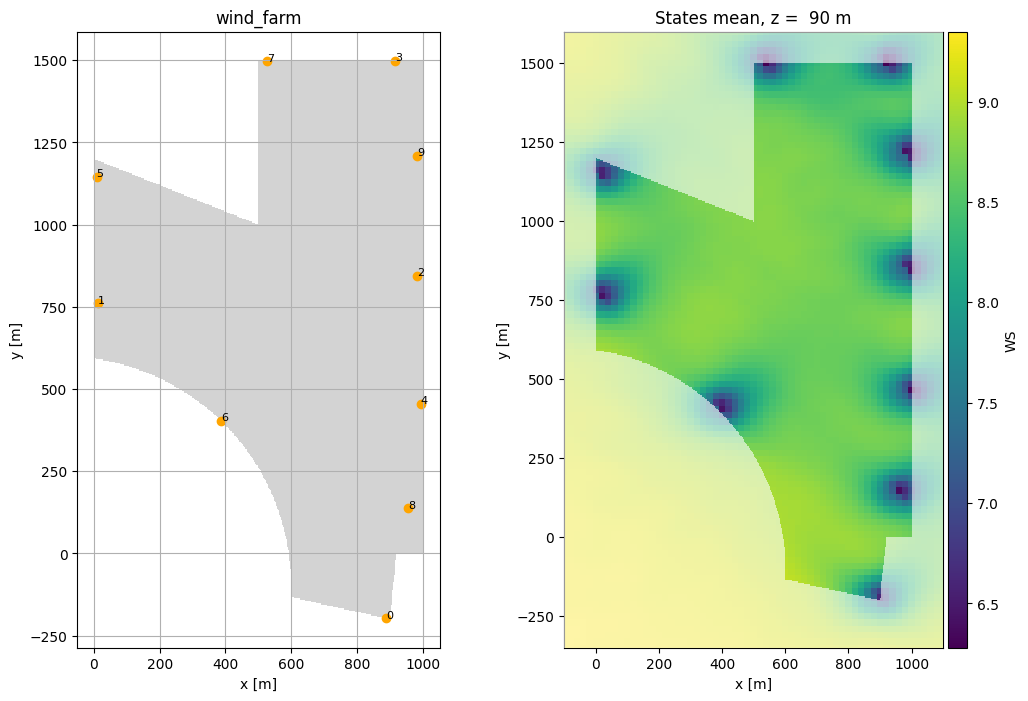

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

foxes.output.FarmLayoutOutput(farm).get_figure(fig=fig, ax=axs[0])

o = foxes.output.FlowPlots2D(algo, results.problem_results)
p_min = np.array([-100.0, -350.0])
p_max = np.array([1100.0, 1600.0])
fig = o.get_mean_fig_xy(
    "WS",
    resolution=20,
    fig=fig,
    ax=axs[1],
    xmin=p_min[0],
    xmax=p_max[0],
    ymin=p_min[1],
    ymax=p_max[1],
)
dpars = dict(alpha=0.6, zorder=10, p_min=p_min, p_max=p_max)
farm.boundary.add_to_figure(axs[1], fill_mode="outside_white", pars_distance=dpars)

plt.show()

Finally, now that all calculations are done, we close the engine:

In [11]:
engine.finalize()